In [105]:
# import libraries
import os
import random

import numpy as np
import torch
from torchvision import datasets
from torchvision.transforms import v2
from PIL import Image
import tqdm
import matplotlib.pyplot as plt

# **Set HyperParameters**

In [142]:
# configs
CFG = {
    "seed": 42,
    "img_size": 224,
    "batch_size": 32,
    "num_workers": 2,
    "num_epochs": 25
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "mean": [0.485, 0.456, 0.406], 
    "std": [0.229, 0.224, 0.225]
}
toImage = lambda img_batch: (img_batch.permute(1,2,0).cpu().numpy()* np.array(CFG["std"]) + np.array(CFG["mean"])).clip(0, 1)

print(f"Device:", CFG["device"])

Device: cuda


### **Make Deterministic**

In [107]:
# set deterministic randoms
random.seed(CFG["seed"])
np.random.seed(CFG["seed"])
torch.manual_seed(CFG["seed"])
torch.cuda.manual_seed_all(CFG["seed"])
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [108]:
INPUT_DIR = os.path.join('/', 'kaggle','input')
DATASET_NAME = os.listdir(INPUT_DIR)[0]
DATASET_DIR = os.path.join(INPUT_DIR, DATASET_NAME)

test_path = os.path.join(DATASET_DIR,'test')
train_path = os.path.join(DATASET_DIR,'train')
val_path = os.path.join(DATASET_DIR, 'validation')

if os.path.exists(test_path) and os.path.exists(train_path) and os.path.exists(val_path):
    print(f'All directories found.')
else:
    raise FileNotFoundError(f'Directories:\n\tTest ({test_path}): {os.path.exists(test_path)};\n\tTrain ({train_path}): {os.path.exists(train_path)};\n\tValidation ({val_path}): {os.path.exists(val_path)};')

All directories found.


In [146]:
# transforms to train and validation datasets
train_transforms = v2.Compose([
    v2.ToImage(),
    v2.RandomResizedCrop(size=(CFG['img_size'], CFG['img_size']), antialias=True),
    v2.RandomHorizontalFlip(p = 0.5),
    # v2.RandomRotation(degrees=(-15, 15)),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=CFG['mean'], std=CFG['std']),
])
val_transforms = v2.Compose([
    v2.ToImage(),
    v2.Resize(size=(int(CFG['img_size'] * 1.1),), antialias=True), 
    v2.CenterCrop(size=(CFG['img_size'], CFG['img_size'])),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=CFG['mean'], std=CFG['std']),
])

In [147]:
train_dataset = datasets.ImageFolder(train_path, transform = train_transforms)

val_dataset = datasets.ImageFolder(val_path, transform = val_transforms)
test_dataset = datasets.ImageFolder(test_path, transform = val_transforms)

test_dataset, train_dataset, val_dataset

(Dataset ImageFolder
     Number of datapoints: 359
     Root location: /kaggle/input/fruit-and-vegetable-image-recognition/test
     StandardTransform
 Transform: Compose(
                  ToImage()
                  Resize(size=[246], interpolation=InterpolationMode.BILINEAR, antialias=True)
                  CenterCrop(size=(224, 224))
                  ToDtype(scale=True)
                  Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
            ),
 Dataset ImageFolder
     Number of datapoints: 3115
     Root location: /kaggle/input/fruit-and-vegetable-image-recognition/train
     StandardTransform
 Transform: Compose(
                  ToImage()
                  RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=InterpolationMode.BILINEAR, antialias=True)
                  RandomHorizontalFlip(p=0.5)
                  ToDtype(scale=True)
                  Normalize(mean=[0.485, 0.456, 0.406], 

In [148]:
# load the data
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size = CFG["batch_size"],
    shuffle = True, num_workers = CFG['num_workers']
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size = CFG["batch_size"],
    shuffle = False, num_workers = CFG['num_workers']
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size = CFG["batch_size"],
    shuffle = False, num_workers = 0
)
len(train_dataloader), len(val_dataloader), len(test_dataloader),

(98, 11, 12)

In [151]:
if train_dataset.classes == val_dataset.classes == test_dataset.classes:
    label_names = train_dataset.classes
    num_classes = len(label_names)
    print(f'All label names: {label_names}')
    print(f'\nNumber of labels: {num_classes}')
else:
    raise ValueError("Different Class Names")

All label names: ['apple', 'banana', 'beetroot', 'bell pepper', 'cabbage', 'capsicum', 'carrot', 'cauliflower', 'chilli pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'grapes', 'jalepeno', 'kiwi', 'lemon', 'lettuce', 'mango', 'onion', 'orange', 'paprika', 'pear', 'peas', 'pineapple', 'pomegranate', 'potato', 'raddish', 'soy beans', 'spinach', 'sweetcorn', 'sweetpotato', 'tomato', 'turnip', 'watermelon']

Number of labels: 36


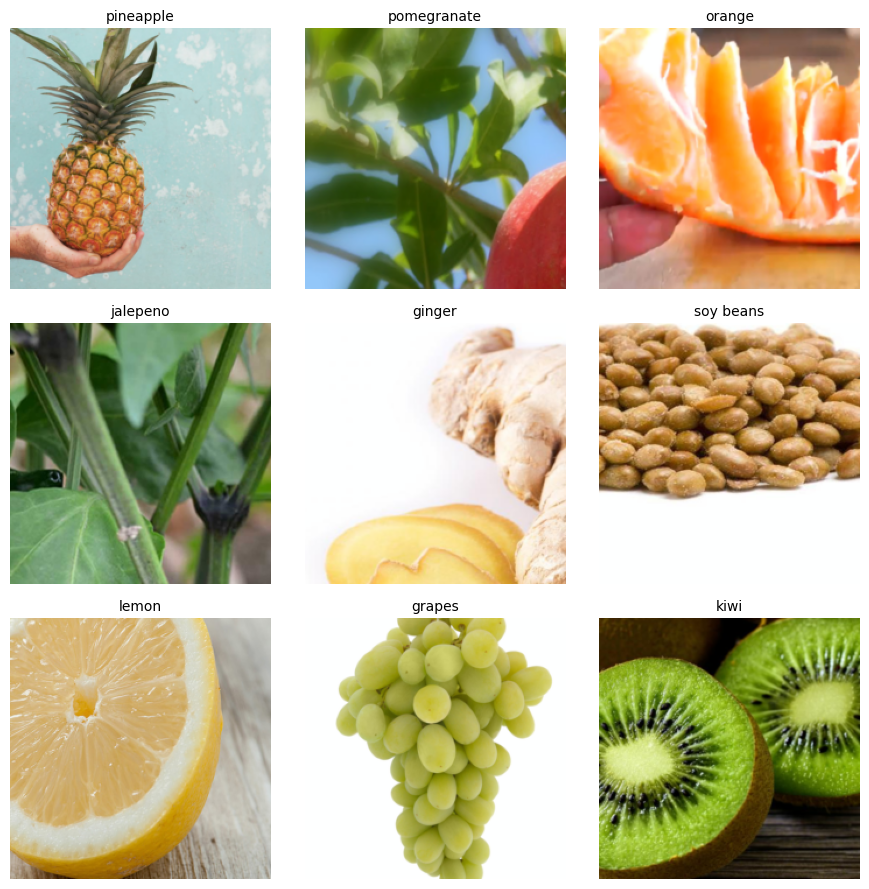

In [152]:
def show_images(loader, n=12, cols=4):
    X_batch, y_batch = next(iter(loader))

    n = min(n, len(X_batch))
    rows = (n + cols - 1) // cols

    plt.figure(figsize=(3*cols, 3*rows))
    for i in range(n):
        img, label = toImage(X_batch[i]), label_names[y_batch[i].item()]
        
        plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.title(label, fontsize=10)
        plt.axis("off")

    plt.tight_layout()
    plt.show()
show_images(train_dataloader, n=9, cols=3)

In [153]:
from tqdm import tqdm
import torch

def train_model(model, criterion, optimizer, scheduler, num_epochs, device):
    artifacts = {
        "train": {"loss": [], "accuracy": []},
        "val":   {"loss": [], "accuracy": []},
    }

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
                dataloader = train_dataloader
            else:
                model.eval()
                dataloader = val_dataloader

            running_loss = 0.0
            running_correct = 0
            running_total = 0

            for X, y in tqdm(dataloader, desc=phase):
                X = X.to(device)
                y = y.to(device)

                if phase == "train":
                    optimizer.zero_grad(set_to_none=True)

                with torch.set_grad_enabled(phase == "train"):
                    logits = model(X)
                    loss = criterion(logits, y)
                    preds = logits.argmax(dim=1)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                bs = y.size(0)
                running_loss += loss.item() * bs
                running_correct += (preds == y).sum().item()
                running_total += bs

            epoch_loss = running_loss / running_total
            epoch_acc  = running_correct / running_total

            artifacts[phase]["loss"].append(epoch_loss)
            artifacts[phase]["accuracy"].append(epoch_acc)

            print(f"{phase}: loss={epoch_loss:.4f} acc={epoch_acc:.4f}")

        if scheduler is not None:
            scheduler.step()

    return model, artifacts

In [ ]:
model = torchvision.models.resnet34(pretrained = True)
optimizer =